In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
data = pd.read_csv('Hasil_Gabungan.csv')

In [2]:
featuress = [
    'Residential_2021', 'Industrial_2021', 'Business_2021', 'Social_2021', 'Gov_Office_2021', 
    'Pub_Street_2021', 'Total_2021', 'Residential_2022', 'Industrial_2022', 'Business_2022', 
    'Social_2022', 'Gov_Office_2022', 'Pub_Street_2022', 'Total_2022', 'Residential', 
    'Industrial', 'Business', 'Social', 'Gov_Office', 'Pub_Street', 'Total', 
    'JP_2021', 'JP_2022', 'JP_2023', 'KP_2021', 'KP_2022', 'KP_2023'
]

data_ = data[featuress]
scaler = RobustScaler()
scaled_features = scaler.fit_transform(data_)

def optimize_fcm(X, m_values, error_values, maxiter_values, n_clusters_range):
    best_sil_score = -1
    best_params = None
    best_model = None

    for m in m_values:
        for error in error_values:
            for maxiter in maxiter_values:
                for n_clusters in n_clusters_range:
                    cntr, u, _, _, _, _, _ = fuzz.cmeans(X.T, c=n_clusters, m=m, error=error, maxiter=maxiter, init=None)
                    labels = np.argmax(u, axis=0)

                    sil_score = silhouette_score(X, labels)
                    if sil_score > best_sil_score:
                        best_sil_score = sil_score
                        best_params = (m, error, maxiter, n_clusters)
                        best_model = (cntr, u)

    return best_params, best_sil_score, best_model

m_values = [1.5, 2, 2.5, 3]
error_values = [0.001, 0.005, 0.01]
maxiter_values = [100, 500, 1000]
n_clusters_range = range(2, 6)

best_params, best_sil_score, best_model = optimize_fcm(scaled_features, m_values, error_values, maxiter_values, n_clusters_range)

print(f"Best Parameters: m={best_params[0]}, error={best_params[1]}, maxiter={best_params[2]}, n_clusters={best_params[3]}")
print(f"Best Silhouette Score: {best_sil_score}")



Best Parameters: m=1.5, error=0.001, maxiter=100, n_clusters=3
Best Silhouette Score: 0.8134610115525492


In [3]:
data_ = data[featuress]

scaler = RobustScaler()
scaled_features = scaler.fit_transform(data_)

n_clusters = 2

cntr, u, _, _, _, _, _ = fuzz.cmeans(scaled_features.T, c=n_clusters, m=1.5, error=0.001, maxiter=100, init=None)

labels = np.argmax(u, axis=0)

cluster_provinces = {}
provinces = data['Province'].tolist()  

for cluster_idx in range(n_clusters):
    cluster_provinces[cluster_idx] = [provinces[i] for i in range(len(labels)) if labels[i] == cluster_idx]

for cluster_idx, provinces_in_cluster in cluster_provinces.items():
    print(f"Cluster {cluster_idx + 1}: {', '.join(provinces_in_cluster)}")

sil_score = silhouette_score(scaled_features, labels)
print(f"Silhouette Score: {sil_score}")

Cluster 1: Jawa Timur, Jawa Tengah, Jawa Barat, Banten, DKI Jakarta
Cluster 2: Aceh, Sumatera Utara, Sumatera Barat, Riau, Kep. Riau, Sumatera Selatan, Jambi, Bengkulu, Kep. Bangka Belitung, Lampung, Kalimantan Barat, Kalimantan Selatan, Kalimantan Tengah, Sulawesi Utara, Gorontalo, Sulawesi Tengah, Sulawesi Selatan, Sulawesi Tenggara, Sulawesi Barat, Maluku, Maluku Utara, Papua, Papua Barat, Bali, Nusa Tenggara Barat, Nusa Tenggara Timur, DI Yogyakarta, Kalimantan Timur, Kalimantan Utara
Silhouette Score: 0.8098681704159247


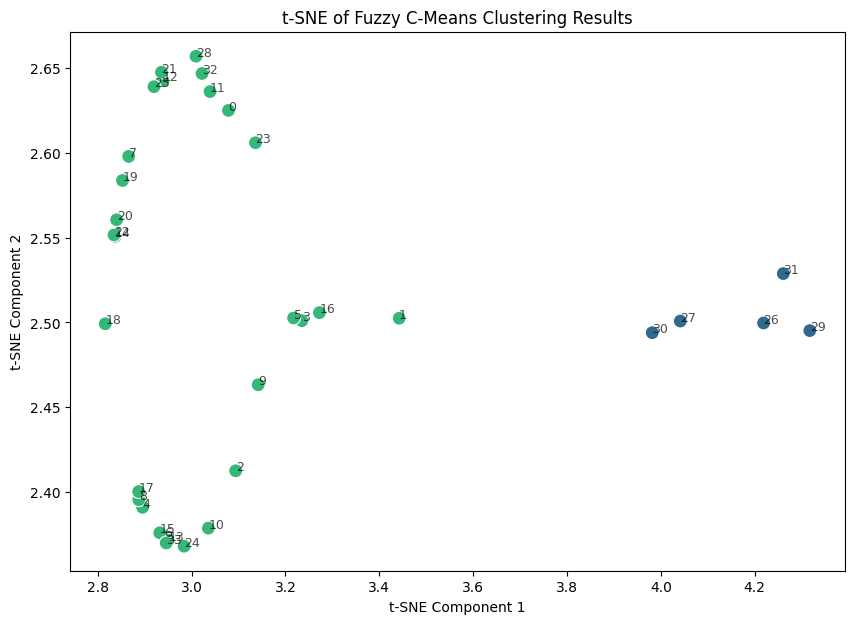

In [4]:
def plot_tsne_with_clusters(X, labels, provinsi_names):
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X) 

    df_tsne = pd.DataFrame(data=X_tsne, columns=['tSNE1', 'tSNE2'])
    df_tsne['Cluster'] = labels
    df_tsne['Provinsi'] = provinsi_names 

    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df_tsne, x='tSNE1', y='tSNE2', hue='Cluster', palette='viridis', s=100, legend=None)

    for i in range(len(provinsi_names)):
        plt.text(df_tsne.loc[i, 'tSNE1'], df_tsne.loc[i, 'tSNE2'], str(i), fontsize=9, alpha=0.7)
    
    plt.title('t-SNE of Fuzzy C-Means Clustering Results')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

plot_tsne_with_clusters(scaled_features, labels, data['Province'].tolist())